<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.01 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 14:11:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.7MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 143kB 37.1MB/s 
     |████████████████████████████████| 143kB 35.8MB/s 
     |████████████████████████████████| 174kB 36.6MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 7r26scj8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/7r26scj8


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: spq3zcy8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 29s 110ms/step - loss: 0.2291 - mean_squared_error: 0.2291 - mean_absolute_error: 0.3998 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0940
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0728 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0857
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0619 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0787
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0553 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0744
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0044 - mean_squared_err

wandb: Agent Starting Run: i0rozmik with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 13s 338ms/step - loss: 2.1766 - mean_squared_error: 2.1766 - mean_absolute_error: 1.1211 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1338
Epoch 2/100
8/8 [==============================] - 2s 189ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1081 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1508
Epoch 3/100
8/8 [==============================] - 1s 181ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1391 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1442
Epoch 4/100
8/8 [==============================] - 2s 193ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1293 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1075
Epoch 5/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0196 - mean_squared_erro

wandb: Agent Starting Run: aivuyrp1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 9s 253ms/step - loss: 0.3887 - mean_squared_error: 0.3887 - mean_absolute_error: 0.3626 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0968
Epoch 2/50
16/16 [==============================] - 3s 183ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0936 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0961
Epoch 3/50
16/16 [==============================] - 3s 187ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0996 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1056
Epoch 4/50
16/16 [==============================] - 3s 186ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0758 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1129
Epoch 5/50
16/16 [==============================] - 3s 192ms/step - loss: 0.0126 - mean_squared_

wandb: Agent Starting Run: g30r31d2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 96ms/step - loss: 0.1232 - mean_squared_error: 0.1232 - mean_absolute_error: 0.2701 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0957
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0934 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0878
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0695
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0464 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0640
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error

wandb: Agent Starting Run: oewrq8wp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 368ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - mean_absolute_error: 0.4076 - val_loss: 0.1208 - val_mean_squared_error: 0.1208 - val_mean_absolute_error: 0.2830
Epoch 2/50
8/8 [==============================] - 1s 185ms/step - loss: 0.1158 - mean_squared_error: 0.1158 - mean_absolute_error: 0.2821 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1304
Epoch 3/50
8/8 [==============================] - 2s 190ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1136 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1640
Epoch 4/50
8/8 [==============================] - 2s 189ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1228 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0948
Epoch 5/50
8/8 [==============================] - 1s 185ms/step - loss: 0.0098 - mean_squared_error: 0.0

wandb: Agent Starting Run: ry4pdaq4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 327ms/step - loss: 0.2178 - mean_squared_error: 0.2178 - mean_absolute_error: 0.2992 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0795
Epoch 2/50
8/8 [==============================] - 2s 189ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0784 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0795
Epoch 3/50
8/8 [==============================] - 2s 192ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0837 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0754
Epoch 4/50
8/8 [==============================] - 2s 199ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0760 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1007
Epoch 5/50
8/8 [==============================] - 2s 207ms/step - loss: 0.0151 - mean_squared_error: 0.0

wandb: Agent Starting Run: zy44uv20 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 12s 245ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2254 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0781
Epoch 2/50
31/31 [==============================] - 6s 190ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0688 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0824
Epoch 3/50
31/31 [==============================] - 6s 193ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0671 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0893
Epoch 4/50
31/31 [==============================] - 6s 189ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0642 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0683
Epoch 5/50
31/31 [==============================] - 5s 171ms/step - loss: 0.0062 - mean_squared

wandb: Agent Starting Run: kbupgkvz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 11s 233ms/step - loss: 0.1062 - mean_squared_error: 0.1062 - mean_absolute_error: 0.2215 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0698
Epoch 2/200
31/31 [==============================] - 6s 193ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0624 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1044
Epoch 3/200
31/31 [==============================] - 6s 194ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0594 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0811
Epoch 4/200
31/31 [==============================] - 6s 195ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0772
Epoch 5/200
31/31 [==============================] - 6s 196ms/step - loss: 0.0056 - mean_sq

wandb: Agent Starting Run: jbck93id with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 438ms/step - loss: 0.2812 - mean_squared_error: 0.2812 - mean_absolute_error: 0.4623 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - val_mean_absolute_error: 0.3785
Epoch 2/50
8/8 [==============================] - 2s 197ms/step - loss: 0.2241 - mean_squared_error: 0.2241 - mean_absolute_error: 0.4071 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - val_mean_absolute_error: 0.2780
Epoch 3/50
8/8 [==============================] - 2s 196ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2726 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1138
Epoch 4/50
8/8 [==============================] - 1s 188ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0946 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1057
Epoch 5/50
8/8 [==============================] - 2s 187ms/step - loss: 0.0089 - mean_squared_error: 0.0

wandb: Agent Starting Run: 2mahxan9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 374ms/step - loss: 0.1333 - mean_squared_error: 0.1333 - mean_absolute_error: 0.2499 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1346
Epoch 2/100
8/8 [==============================] - 2s 194ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1036 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0796
Epoch 3/100
8/8 [==============================] - 2s 186ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0608 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0791
Epoch 4/100
8/8 [==============================] - 2s 192ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0716
Epoch 5/100
8/8 [==============================] - 2s 195ms/step - loss: 0.0051 - mean_squared_error

wandb: Agent Starting Run: a22st16h with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 451ms/step - loss: 1.3055 - mean_squared_error: 1.3055 - mean_absolute_error: 0.9483 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1319
Epoch 2/100
8/8 [==============================] - 2s 189ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1120 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0648
Epoch 3/100
8/8 [==============================] - 2s 187ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1037 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0753
Epoch 4/100
8/8 [==============================] - 2s 201ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0722 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0857
Epoch 5/100
8/8 [==============================] - 2s 201ms/step - loss: 0.0264 - mean_squared_error

wandb: Agent Starting Run: 3gbfmnpd with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 11s 217ms/step - loss: 0.2558 - mean_squared_error: 0.2558 - mean_absolute_error: 0.3163 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0738
Epoch 2/200
31/31 [==============================] - 6s 193ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0599 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1038
Epoch 3/200
31/31 [==============================] - 6s 186ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0592
Epoch 4/200
31/31 [==============================] - 6s 188ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0545
Epoch 5/200
31/31 [==============================] - 6s 181ms/step - loss: 0.0029 - mean_sq

wandb: Agent Starting Run: cjm19uyy with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 406ms/step - loss: 0.2626 - mean_squared_error: 0.2626 - mean_absolute_error: 0.3915 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1054
Epoch 2/200
8/8 [==============================] - 2s 206ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0849 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0775
Epoch 3/200
8/8 [==============================] - 2s 191ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0664 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0710
Epoch 4/200
8/8 [==============================] - 2s 203ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0760
Epoch 5/200
8/8 [==============================] - 2s 214ms/step - loss: 0.0064 - mean_squared_error

wandb: Agent Starting Run: 1vyjimho with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 9s 264ms/step - loss: 0.2280 - mean_squared_error: 0.2280 - mean_absolute_error: 0.4060 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0944
Epoch 2/200
16/16 [==============================] - 3s 162ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1039 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0921
Epoch 3/200
16/16 [==============================] - 3s 188ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0827 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0926
Epoch 4/200
16/16 [==============================] - 3s 200ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0615 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0730
Epoch 5/200
16/16 [==============================] - 3s 194ms/step - loss: 0.0044 - mean_squ

wandb: Agent Starting Run: fomsjf7g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 12s 231ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2661 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0772
Epoch 2/100
31/31 [==============================] - 6s 195ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0560 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0711
Epoch 3/100
31/31 [==============================] - 6s 185ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0491 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0786
Epoch 4/100
31/31 [==============================] - 6s 190ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0541 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0733
Epoch 5/100
31/31 [==============================] - 6s 190ms/step - loss: 0.0044 - mean_sq

wandb: Agent Starting Run: xt9bpbyt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 96ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - mean_absolute_error: 0.3590 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1165
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0782 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0897
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0632 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0825
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0740
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_

wandb: Agent Starting Run: yw0e5oz0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 7s 56ms/step - loss: 0.1534 - mean_squared_error: 0.1534 - mean_absolute_error: 0.3011 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0851
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0610 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0751
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0505 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0692
Epoch 4/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0478 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0680
Epoch 5/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_squared_error

wandb: Agent Starting Run: l9kfrvd2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 11s 226ms/step - loss: 0.2399 - mean_squared_error: 0.2399 - mean_absolute_error: 0.4051 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1464
Epoch 2/50
31/31 [==============================] - 6s 191ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.1013 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0867
Epoch 3/50
31/31 [==============================] - 6s 187ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0648 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0761
Epoch 4/50
31/31 [==============================] - 5s 170ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0742
Epoch 5/50
31/31 [==============================] - 6s 191ms/step - loss: 0.0049 - mean_squared

wandb: Agent Starting Run: do6cdxn5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 91ms/step - loss: 0.2142 - mean_squared_error: 0.2142 - mean_absolute_error: 0.3717 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1895
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1271 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0892
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0716 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0862
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0517 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0730
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_

wandb: Agent Starting Run: j0bl4sp6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 6s 189ms/step - loss: 0.1757 - mean_squared_error: 0.1757 - mean_absolute_error: 0.3526 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1032
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1025 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1637
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1076 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0844
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0792 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0808
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.

wandb: Agent Starting Run: 8tzsgy25 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 9s 269ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - mean_absolute_error: 0.2084 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0738
Epoch 2/50
16/16 [==============================] - 3s 189ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0689 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0676
Epoch 3/50
16/16 [==============================] - 3s 203ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0527 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0661
Epoch 4/50
16/16 [==============================] - 3s 193ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0554 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0627
Epoch 5/50
16/16 [==============================] - 3s 192ms/step - loss: 0.0043 - mean_squared_

wandb: Agent Starting Run: 9lphfje0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 7s 371ms/step - loss: 0.4504 - mean_squared_error: 0.4504 - mean_absolute_error: 0.5594 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1589
Epoch 2/200
8/8 [==============================] - 2s 214ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1505 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0815
Epoch 3/200
8/8 [==============================] - 2s 194ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0829 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0600
Epoch 4/200
8/8 [==============================] - 2s 199ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0542 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0692
Epoch 5/200
8/8 [==============================] - 2s 195ms/step - loss: 0.0043 - mean_squared_error

wandb: Agent Starting Run: h1i13kjh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 12s 231ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1054 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0663
Epoch 2/50
31/31 [==============================] - 6s 195ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0508 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0630
Epoch 3/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0448 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0634
Epoch 4/50
31/31 [==============================] - 6s 191ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0690
Epoch 5/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0044 - mean_squared

wandb: Agent Starting Run: 75v4j3fg with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 12s 236ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - mean_absolute_error: 0.2481 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0553
Epoch 2/200
31/31 [==============================] - 6s 194ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0454 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0543
Epoch 3/200
31/31 [==============================] - 6s 186ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0422 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0563
Epoch 4/200
31/31 [==============================] - 6s 195ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0404 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0538
Epoch 5/200
31/31 [==============================] - 6s 192ms/step - loss: 0.0023 - mean_sq

wandb: Agent Starting Run: ltejpu82 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 388ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - mean_absolute_error: 0.3401 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1232
Epoch 2/100
8/8 [==============================] - 2s 195ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1876 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0932
Epoch 3/100
8/8 [==============================] - 2s 204ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0783 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0742
Epoch 4/100
8/8 [==============================] - 2s 192ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0646 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0861
Epoch 5/100
8/8 [==============================] - 2s 201ms/step - loss: 0.0099 - mean_squared_error

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 0.005,
    'dropout': 0.2,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
10/10 [==============================] - 6s 147ms/step - loss: 0.6963
Epoch 2/200
10/10 [==============================] - 1s 149ms/step - loss: 0.0139
Epoch 3/200
10/10 [==============================] - 2s 154ms/step - loss: 0.0060
Epoch 4/200
10/10 [==============================] - 1s 146ms/step - loss: 0.0047
Epoch 5/200
10/10 [==============================] - 2s 154ms/step - loss: 0.0034
Epoch 6/200
10/10 [==============================] - 1s 143ms/step - loss: 0.0037
Epoch 7/200
10/10 [==============================] - 1s 148ms/step - loss: 0.0035
Epoch 8/200
10/10 [==============================] - 2s 152ms/step - loss: 0.0029
Epoch 9/200
10/10 [==============================] - 1s 147ms/step - loss: 0.0026
Epoch 10/200
10/10 [==============================] - 1s 148ms/step - loss: 0.0025
Epoch 11/200
10/10 [==============================] - 1s 141ms/step - loss: 0.0029
Epoch 12/200
10/10 [==============================] - 2s 151ms/step - loss: 0.0023
Epoch 13/200


In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

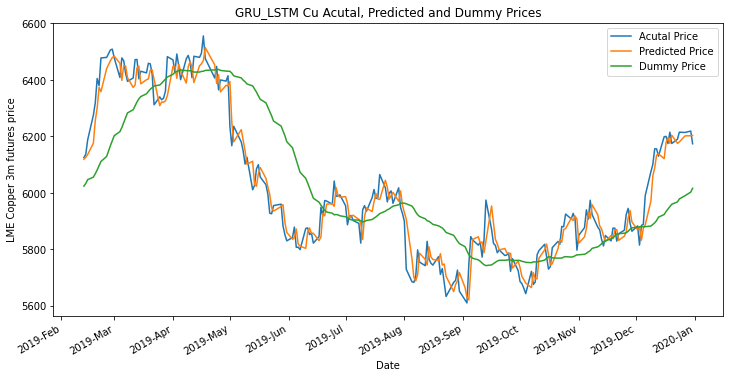

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

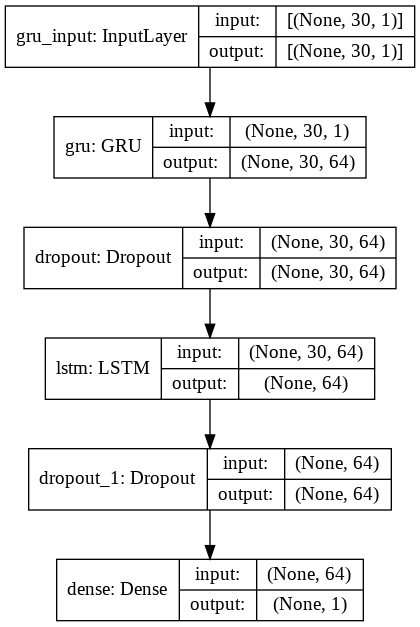

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0030136207231918804
RMSE:  0.05489645455939646
MAE:  0.043444185338658084
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Cu/assets
